In [10]:
#Importing libraries
import numpy as np
import pandas as pd
#import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from time import time
from sklearn.metrics import r2_score
import os

In [11]:
data = pd.read_csv('kc_house_data.csv')
df = data.copy()

In [12]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [14]:
# Check any number of columns with NaN or missing values 
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


<AxesSubplot:>

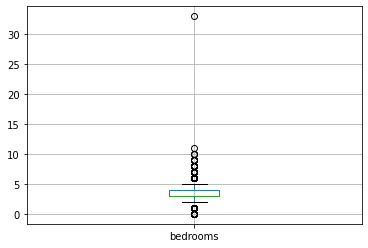

In [15]:
# Are there any outliers?
df.boxplot(column=['bedrooms'])

In [18]:
df_new = df.drop_duplicates()
df_new.info() # No duplicates found

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [19]:
# Sorting the data by price to see if there are any similarities on the top 5
df_ordered = df.sort_values(by=['price'], inplace=False, ascending=False)
df_ordered.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
4411,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1448,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750


<AxesSubplot:xlabel='bedrooms', ylabel='price'>

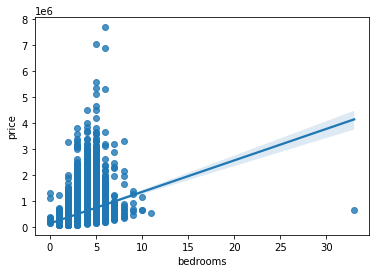

In [20]:
sns.regplot(x='bedrooms',y='price', data=df_new)

<AxesSubplot:xlabel='grade', ylabel='price'>

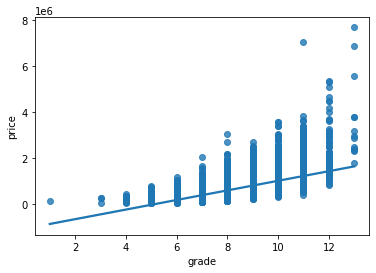

In [21]:
sns.regplot(x='grade', y='price', data=df_new)

In [22]:
# Time to cleanup the data and put it into a more user-friendly format.
# Date to be cleaned, price to integer, select only some of the columns
# for correlation
df_new['date_updated'] = df_new['date'].apply(lambda x: x[:8])
print(df_new.head())
df_new['date_updated'] = pd.to_datetime(df_new['date_updated'], format='%Y%m%d')
print(df_new.head())


           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...        1180              0   
1      7242     2.0           0     0  ...        2170            400   
2     10000     1.0           0     0  ...         770              0   
3      5000     1.0           0     0  ...        1050            910   
4      8080     1.0           0     0  ...        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955          

In [23]:
df_new['date_updated'].dtype

dtype('<M8[ns]')

Check photo C:\Users\Admin\Pictures\Screenshots\Screenshot 2022-08-23 211810 .About more info on lamda

In [24]:
# Price to integer
df_new['price_int'] = df_new.price.astype(int)
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_updated,price_int
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014-10-13,221900
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014-12-09,538000
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015-02-25,180000
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014-12-09,604000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015-02-18,510000


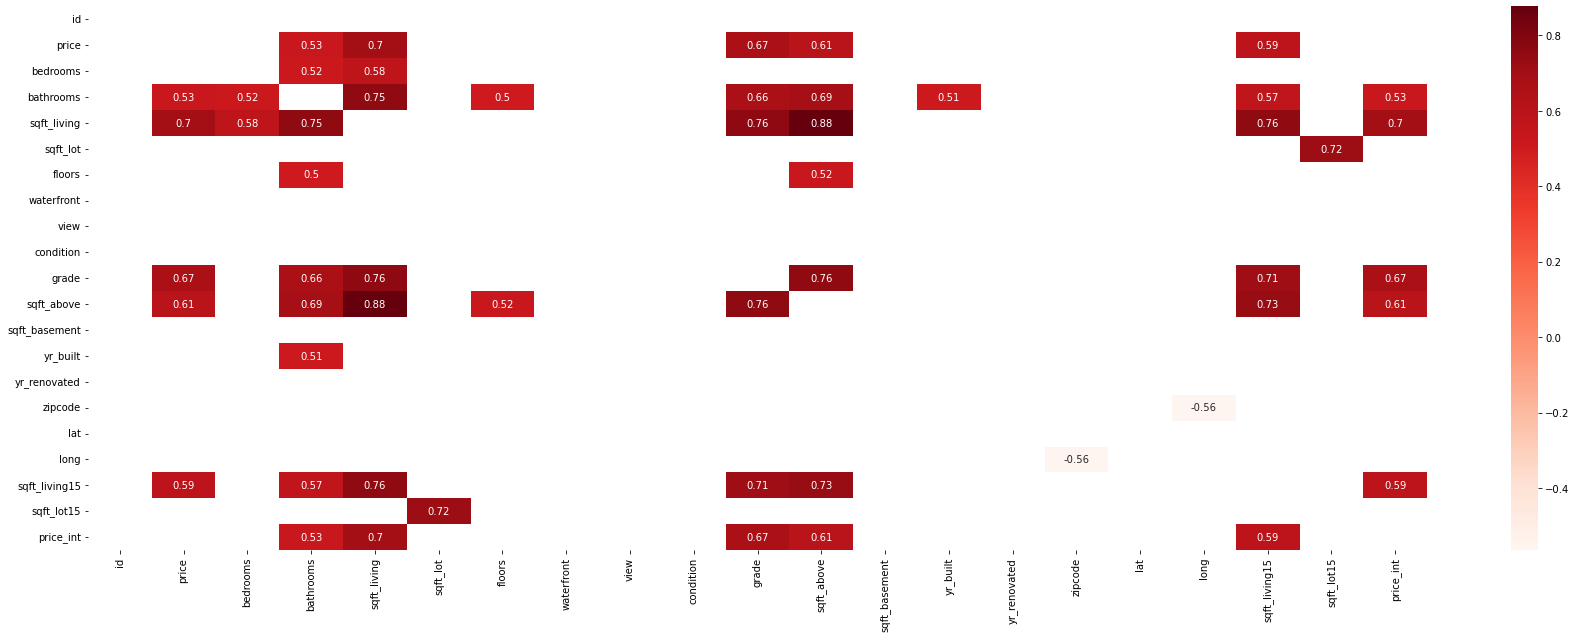

In [25]:
# Selecting the columns for correlation
df_new_corr = df_new.corr()
df_new_corr_filtered = df_new_corr[((df_new_corr >=.5) | (df_new_corr <= -.5)) &
                                  (df_new_corr != 1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(df_new_corr_filtered, annot=True, cmap='Reds')
plt.show()

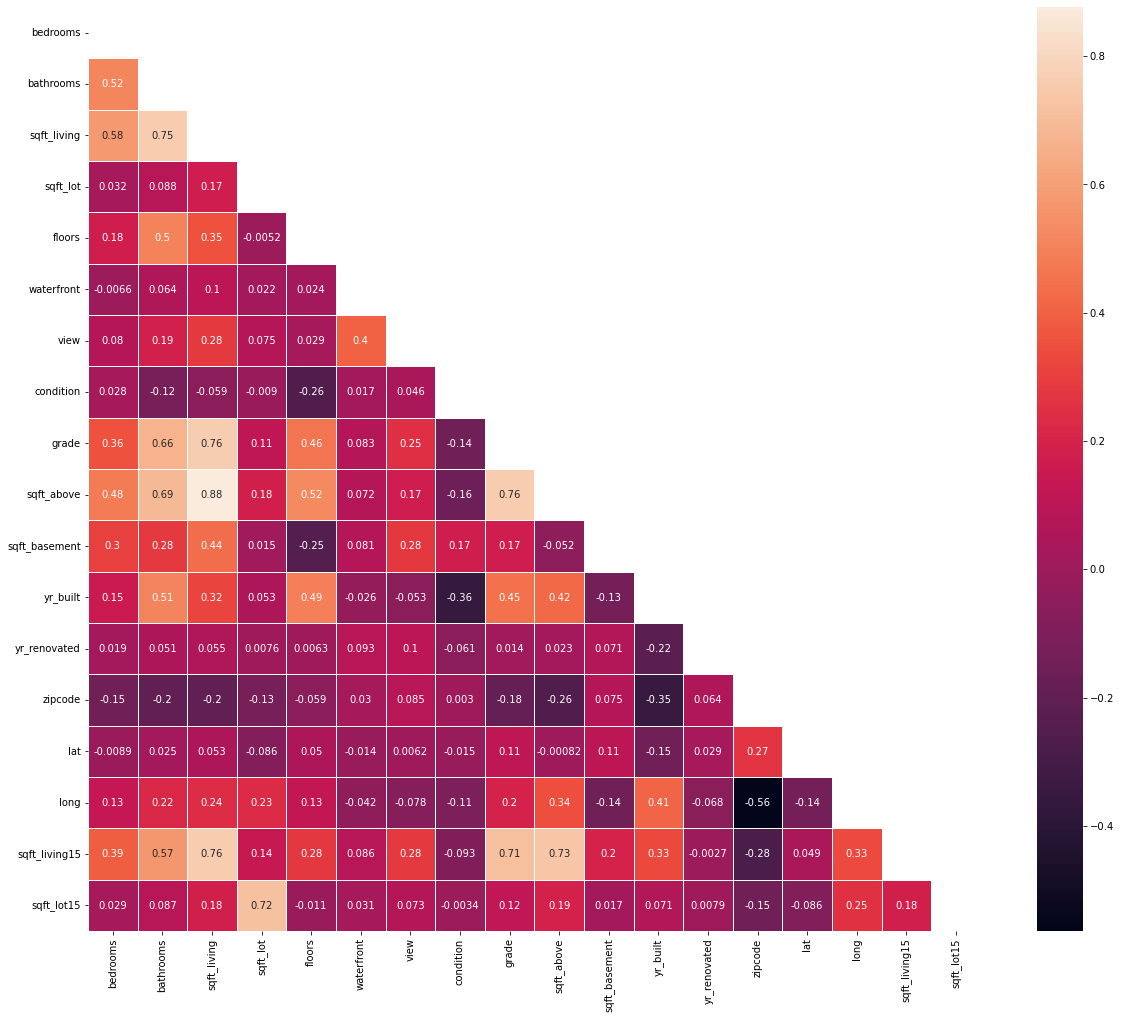

In [26]:
corr_data = df.drop(['id','date','price'], axis=1)
plt.figure(figsize=(20,17))
matrix = np.triu(corr_data.corr())
sns.heatmap(corr_data.corr(), annot=True, linewidth=.8, mask=matrix, cmap='rocket' );

In [27]:
correlation_mat = df_new.apply(lambda x: x.factorize()[0]).corr()
corr_pairs = correlation_mat.unstack()

print(corr_pairs)

id         id               1.000000
           date             0.025680
           price            0.231507
           bedrooms         0.009758
           bathrooms        0.072470
                              ...   
price_int  long             0.016578
           sqft_living15    0.115368
           sqft_lot15       0.120915
           date_updated     0.005816
           price_int        1.000000
Length: 529, dtype: float64


In [28]:
sorted_pairs = corr_pairs.sort_values(kind='quicksort')
pd.set_option('display.max_rows', None)
sorted_pairs

floors         condition       -0.175250
condition      floors          -0.175250
grade          condition       -0.142126
condition      grade           -0.142126
sqft_above     condition       -0.124158
condition      sqft_above      -0.124158
               sqft_lot        -0.116813
sqft_lot       condition       -0.116813
bathrooms      condition       -0.116498
condition      bathrooms       -0.116498
floors         sqft_basement   -0.109345
sqft_basement  floors          -0.109345
condition      sqft_lot15      -0.104477
sqft_lot15     condition       -0.104477
condition      id              -0.099943
id             condition       -0.099943
sqft_living    condition       -0.092802
condition      sqft_living     -0.092802
sqft_living15  condition       -0.082177
condition      sqft_living15   -0.082177
zipcode        floors          -0.051771
floors         zipcode         -0.051771
long           sqft_basement   -0.042836
sqft_basement  long            -0.042836
price          c

In [29]:
strong_pairs = sorted_pairs[((abs(sorted_pairs) >= 0.5) | (abs(sorted_pairs) <= -.5)) & (abs(sorted_pairs) != 1.000)]
strong_pairs

sqft_lot     sqft_lot15     0.512327
sqft_lot15   sqft_lot       0.512327
sqft_above   sqft_living    0.693384
sqft_living  sqft_above     0.693384
dtype: float64

In [30]:
strong_pairs = sorted_pairs[(sorted_pairs > 0.5) ]
strong_pairs

sqft_lot       sqft_lot15       0.512327
sqft_lot15     sqft_lot         0.512327
sqft_above     sqft_living      0.693384
sqft_living    sqft_above       0.693384
price_int      price            1.000000
id             id               1.000000
grade          grade            1.000000
date_updated   date             1.000000
date           date             1.000000
               date_updated     1.000000
price          price            1.000000
               price_int        1.000000
bedrooms       bedrooms         1.000000
bathrooms      bathrooms        1.000000
sqft_living    sqft_living      1.000000
sqft_lot       sqft_lot         1.000000
floors         floors           1.000000
waterfront     waterfront       1.000000
view           view             1.000000
condition      condition        1.000000
sqft_above     sqft_above       1.000000
sqft_basement  sqft_basement    1.000000
yr_built       yr_built         1.000000
yr_renovated   yr_renovated     1.000000
zipcode        z

Text(32.09375, 0.5, 'House features')

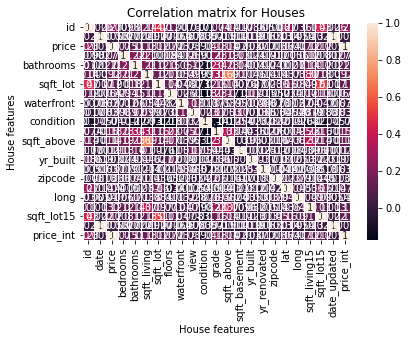

In [31]:
correlation_matrix = df_new.apply(lambda x: x.factorize()[0]).corr(method='pearson')

sns.heatmap(correlation_matrix, annot=True, linewidth=.8, cmap='rocket' );

plt.title("Correlation matrix for Houses")

plt.xlabel("House features")

plt.ylabel("House features")



In [33]:
df_new_corr_filtered_texted = df_new_corr[((df_new_corr >=.5) | (df_new_corr <= -.5)) &
                                  (df_new_corr != 1.000)]
df_new_corr_filtered_texted

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_int
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,NaN,NaN,NaN,0.525138,0.702035,NaN,NaN,NaN,NaN,NaN,...,0.605567,NaN,NaN,NaN,NaN,NaN,NaN,0.585379,NaN,NaN
bedrooms,NaN,NaN,NaN,0.515884,0.576671,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,NaN,0.525138,0.515884,NaN,0.754665,NaN,0.500653,NaN,NaN,NaN,...,0.685342,NaN,0.506019,NaN,NaN,NaN,NaN,0.568634,NaN,0.525138
sqft_living,NaN,0.702035,0.576671,0.754665,NaN,NaN,NaN,NaN,NaN,NaN,...,0.876597,NaN,NaN,NaN,NaN,NaN,NaN,0.756420,NaN,0.702035
sqft_lot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.718557,NaN
floors,NaN,NaN,NaN,0.500653,NaN,NaN,NaN,NaN,NaN,NaN,...,0.523885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
correlation_mat = df_new.corr()
corr_pairs = correlation_mat.unstack()
corr_pairs_new = corr_pairs[((corr_pairs >=.5) | (corr_pairs <= -.5)) &
                                  (corr_pairs != 1.000)]
corr_pairs_new

price          bathrooms        0.525138
               sqft_living      0.702035
               grade            0.667434
               sqft_above       0.605567
               sqft_living15    0.585379
bedrooms       bathrooms        0.515884
               sqft_living      0.576671
bathrooms      price            0.525138
               bedrooms         0.515884
               sqft_living      0.754665
               floors           0.500653
               grade            0.664983
               sqft_above       0.685342
               yr_built         0.506019
               sqft_living15    0.568634
               price_int        0.525138
sqft_living    price            0.702035
               bedrooms         0.576671
               bathrooms        0.754665
               grade            0.762704
               sqft_above       0.876597
               sqft_living15    0.756420
               price_int        0.702035
sqft_lot       sqft_lot15       0.718557
floors         b

In [37]:
corr_pairs_new[0]

0.5251375054139628

In [40]:
type(corr_pairs_new)

pandas.core.series.Series

In [39]:
np.sort(corr_pairs_new)

array([-0.56407161, -0.56407161,  0.50065317,  0.50065317,  0.50601944,
        0.50601944,  0.51588364,  0.51588364,  0.52388471,  0.52388471,
        0.52513751,  0.52513751,  0.52513751,  0.52513751,  0.56863429,
        0.56863429,  0.57667069,  0.57667069,  0.5853789 ,  0.5853789 ,
        0.5853789 ,  0.5853789 ,  0.6055673 ,  0.6055673 ,  0.6055673 ,
        0.6055673 ,  0.66498253,  0.66498253,  0.66743426,  0.66743426,
        0.66743426,  0.66743426,  0.68534248,  0.68534248,  0.70203505,
        0.70203505,  0.70203505,  0.70203505,  0.71320209,  0.71320209,
        0.71855675,  0.71855675,  0.73187029,  0.73187029,  0.75466528,
        0.75466528,  0.75592294,  0.75592294,  0.75642026,  0.75642026,
        0.76270448,  0.76270448,  0.8765966 ,  0.8765966 ])

In [50]:
corr_pairs_new.keys()

MultiIndex([(        'price',     'bathrooms'),
            (        'price',   'sqft_living'),
            (        'price',         'grade'),
            (        'price',    'sqft_above'),
            (        'price', 'sqft_living15'),
            (     'bedrooms',     'bathrooms'),
            (     'bedrooms',   'sqft_living'),
            (    'bathrooms',         'price'),
            (    'bathrooms',      'bedrooms'),
            (    'bathrooms',   'sqft_living'),
            (    'bathrooms',        'floors'),
            (    'bathrooms',         'grade'),
            (    'bathrooms',    'sqft_above'),
            (    'bathrooms',      'yr_built'),
            (    'bathrooms', 'sqft_living15'),
            (    'bathrooms',     'price_int'),
            (  'sqft_living',         'price'),
            (  'sqft_living',      'bedrooms'),
            (  'sqft_living',     'bathrooms'),
            (  'sqft_living',         'grade'),
            (  'sqft_living',    'sqft_a

In [44]:
for i in range(len(corr_pairs_new.keys()[0][1])):
    print(corr_pairs_new[i])

0.5251375054139628
0.7020350546118005
0.6674342560202353
0.6055672983560784
0.5853789035795692
0.5158836376158312
0.5766706925022448
0.5251375054139628
0.5158836376158312
0.7546652789673752
0.5006531725878688
0.6649825338780723
0.6853424758761547
0.5060194382852536
0.568634289578226
0.5251375054139628
0.7020350546118005
0.5766706925022448
0.7546652789673752
0.7627044764584776
0.8765965986813202
0.7564202590172237
0.7020350546118006
0.7185567524330374
0.5006531725878688
0.5238847102851428
0.6674342560202353
0.6649825338780723
0.7627044764584776
0.755922937623647
0.7132020930151698
0.6674342560202353
0.6055672983560784
0.6853424758761547
0.8765965986813202
0.5238847102851428
0.755922937623647
0.7318702923539875
0.6055672983560784
0.5060194382852536
-0.5640716064422665
-0.5640716064422665
0.5853789035795692
0.568634289578226
0.7564202590172237
0.7132020930151698
0.7318702923539875
0.5853789035795692
0.7185567524330374
0.5251375054139628
0.7020350546118006
0.6674342560202353
0.605567298356

In [67]:
for i in range(len(corr_pairs_new.keys())):
    for j in range(len(corr_pairs_new.keys())):
        if corr_pairs_new.keys()[i][j] != 1:
            print(corr_pairs_new.keys()[i][j])
        else:
            pass

price
bathrooms


IndexError: tuple index out of range

In [63]:
if corr_pairs_new.keys()[0][1] != 1:
        print(corr_pairs_new.keys()[1][1])

sqft_living
